In [1]:
import os
import urllib.request
import tarfile

import numpy as np
from matplotlib import pyplot as plt

import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from tqdm import tqdm

from gcv.ensemble import PreSketchedEnsembleRidge, EnsemblePreSketchTransform
from gcv.sketches import CountSketchFactory, SketchSizeParams

In [2]:
# download UCI gene expression cancer RNA-Seq Data Set
# https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz'
DATA_DIR = os.path.expanduser('~/data')
FILE_NAME = 'TCGA-PANCAN-HiSeq-801x20531.tar.gz'
EXTRACT_DIR = 'TCGA-PANCAN-HiSeq-801x20531'

# download data
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(os.path.join(DATA_DIR, EXTRACT_DIR)):
    urllib.request.urlretrieve(URL, os.path.join(DATA_DIR, FILE_NAME))

    # extract data
    tar = tarfile.open(os.path.join(DATA_DIR, FILE_NAME))
    tar.extractall(DATA_DIR)
    tar.close()

# load data
df = pd.read_csv(os.path.join(DATA_DIR, EXTRACT_DIR, 'data.csv'), index_col=0)
targets_df = pd.read_csv(os.path.join(DATA_DIR, EXTRACT_DIR, 'labels.csv'), index_col=0)


In [3]:
classes = ['BRCA', 'KIRC']
dataset_idx = np.where(targets_df.values == classes[0])[0].tolist() + np.where(targets_df.values == classes[1])[0].tolist()

X = df.values[dataset_idx, :]
y = (targets_df.values[dataset_idx, :].ravel() == classes[0]).astype(int) * 2 - 1

rng = np.random.default_rng(0)
idx = rng.permutation(X.shape[0])
n_train = int(0.8 * X.shape[0])
train_idx = idx[:n_train]
test_idx = idx[n_train:]

X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

X_train = (X_train[:, X_std > 0] - X_mean[X_std > 0]) / X_std[X_std > 0]
X_test = (X_test[:, X_std > 0] - X_mean[X_std > 0]) / X_std[X_std > 0]

# save data
np.savez('data/rna-seq.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

n_train, p = X_train.shape
n_test = X_test.shape[0]

(99, 20223)
6572.211796660964


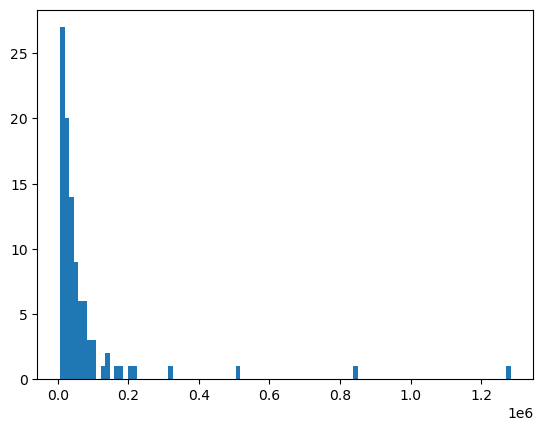

In [4]:
sf = CountSketchFactory(p)
Sh = sf(SketchSizeParams(150))
print(Sh.shape)

# compute the sketch of the training data
Xh_train = Sh @ X_train.T

XX = Xh_train @ Xh_train.T
w, v = np.linalg.eigh(XX)
print(min(w))

plt.hist(w, bins=100)
plt.show()

In [5]:
X_train_norm = X_train
X_test_norm = X_test

In [6]:
def classification_error(y_true, y_pred):
    return np.mean(y_true != np.sign(y_pred))

def gcv_error(estimator, y, y_hat, error_metric):

    div = estimator.gcv_div()
    z = (y_hat - div * y) / (1 - div)

    return error_metric(y, z)

In [17]:
# sketches = ['gaussian', 'orthogonal', 'countsketch', 'dct']
# sketches = ['countsketch', 'dct']
sketches = ['countsketch']
q = 99
n_ens = 5
# Ks = [2, 5, 10]
Ks = [2]
rng = np.random.default_rng(0)
n_trials = 10

lamdas = np.concatenate([-np.logspace(2, 1, 101), np.linspace(-10, 10, 201)[1:], np.logspace(1, 3, 201)[1:]])

cv_reg_errs = np.zeros((n_trials, len(sketches), len(Ks), len(lamdas)))
cv_cls_errs = np.zeros((n_trials, len(sketches), len(Ks), len(lamdas)))
test_reg_errs = np.zeros((n_trials, len(sketches), len(lamdas)))
test_cls_errs = np.zeros((n_trials, len(sketches), len(lamdas)))
gcv_reg_errs = np.zeros((n_trials, len(sketches), len(lamdas)))
gcv_cls_errs = np.zeros((n_trials, len(sketches), len(lamdas)))

for t in range(n_trials):

    for i, sketch in enumerate(sketches):
        sketch_transform = EnsemblePreSketchTransform(n_ens=n_ens, q=q, sketch=sketch, rng=rng)
        XS_train = sketch_transform.fit_transform(X_train_norm)
        XS_test = sketch_transform.transform(X_test_norm)

        # perform k-fold cross validation
        for k, K in enumerate(Ks):

            y_hat_cv = np.zeros((len(lamdas), n_train))

            for train_idx, val_idx in tqdm(KFold(n_splits=K, shuffle=True, random_state=rng.integers(0, 1000)).split(XS_train), total=K, desc=f'{t + 1}/{n_trials}'):
                XS_cv_train = XS_train[train_idx, :]
                y_cv_train = y_train[train_idx]
                XS_cv_val = XS_train[val_idx, :]
                y_cv_val = y_train[val_idx]

                ens = PreSketchedEnsembleRidge(n_ens=n_ens, lamda=lamdas[0], which_ridge='svd').fit(XS_cv_train, y_cv_train)
                y_hat_cv[0, val_idx] = ens.predict(XS_cv_val)

                for j, lamda in enumerate(lamdas[1:]):
                    ens.refit(lamda)
                    y_hat_cv[j + 1, val_idx] = ens.predict(XS_cv_val)
                
            # compute the CV error
            for j in range(len(lamdas)):
                cv_reg_errs[t, i, k, j] = mean_squared_error(y_train, y_hat_cv[j, :])
                cv_cls_errs[t, i, k, j] = classification_error(y_train, y_hat_cv[j, :])
        
        # compute the test error and gcv error
        ens = PreSketchedEnsembleRidge(n_ens=n_ens, lamda=lamdas[0], which_ridge='svd').fit(XS_train, y_train)
        y_train_hat = ens.predict(XS_train)
        y_test_hat = ens.predict(XS_test)
        test_reg_errs[t, i, 0] = mean_squared_error(y_test, y_test_hat)
        gcv_reg_errs[t, i, 0] = gcv_error(ens, y_train, y_train_hat, mean_squared_error)
        test_cls_errs[t, i, 0] = classification_error(y_test, y_test_hat)
        gcv_cls_errs[t, i, 0] = gcv_error(ens, y_train, y_train_hat, classification_error)

        for j, lamda in enumerate(tqdm(lamdas[1:])):
            ens.refit(lamda)
            y_train_hat = ens.predict(XS_train)
            y_test_hat = ens.predict(XS_test)
            test_reg_errs[t, i, j + 1] = mean_squared_error(y_test, y_test_hat)
            gcv_reg_errs[t, i, j + 1] = gcv_error(ens, y_train, y_train_hat, mean_squared_error)
            test_cls_errs[t, i, j + 1] = classification_error(y_test, y_test_hat)
            gcv_cls_errs[t, i, j + 1] = gcv_error(ens, y_train, y_train_hat, classification_error)



100%|██████████| 500/500 [00:00<00:00, 1200.34it/s]


In [29]:
# detect when lamda is too negative and set to nan
lamda_0_i = np.argmin(np.abs(lamdas))
BIG_VAL = 1

for i in range(len(sketches)):
    
    for j in range(len(Ks)):
        cv_idx = np.max(np.argwhere(np.mean(cv_reg_errs[:, i, j, :lamda_0_i], axis=0) > BIG_VAL))
        print(f'cv[{i},{j}]: {cv_idx}')
        cv_reg_errs[:, i, j, :cv_idx] = np.nan
        cv_cls_errs[:, i, j, :cv_idx] = np.nan

    test_idx = np.max(np.argwhere(np.mean(test_reg_errs[:, i, :lamda_0_i], axis=0) > BIG_VAL))
    print(f'test[{i}]: {test_idx}')
    test_reg_errs[:, i, :test_idx] = np.nan
    test_cls_errs[:, i, :test_idx] = np.nan

    gcv_idx = np.max(np.argwhere(np.mean(gcv_reg_errs[:, i, :lamda_0_i], axis=0) > BIG_VAL))
    print(f'gcv[{i}]: {gcv_idx}')
    gcv_reg_errs[:, i, :gcv_idx] = np.nan
    gcv_cls_errs[:, i, :gcv_idx] = np.nan

to_save = {
    'cv_reg_errs': cv_reg_errs,
    'cv_cls_errs': cv_cls_errs,
    'test_reg_errs': test_reg_errs,
    'test_cls_errs': test_cls_errs,
    'gcv_reg_errs': gcv_reg_errs,
    'gcv_cls_errs': gcv_cls_errs,
    'lamdas': lamdas,
    'sketches': sketches,
    'Ks': Ks,
    'n_ens': n_ens,
    'q': q,
    'n_trials': n_trials,
    'p': p,
    'n_train': n_train,
    'n_test': n_test
}

np.savez('results/rna-seq.npz', **to_save)

cv[0,0]: 152
test[0]: 74
gcv[0]: 74


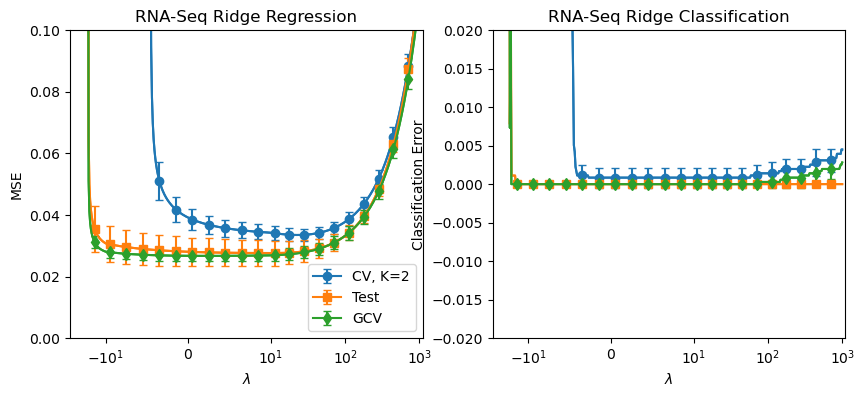

In [28]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_cycle = ['o', 's', 'd', 'v', '^', '<', '>', 'p', 'h', '*']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sketch_i = 0

for k, K in enumerate(Ks):
    markevery = (5, 20)
    axes[0].plot(lamdas, np.mean(cv_reg_errs[:, sketch_i, k, :], axis=0), color=color_cycle[k])
    axes[0].errorbar(lamdas, np.mean(cv_reg_errs[:, sketch_i, k, :], axis=0), yerr=np.std(cv_reg_errs[:, sketch_i, k, :], axis=0), errorevery=markevery, markevery=markevery, marker=marker_cycle[k], color=color_cycle[k], capsize=3, label=f'CV, K={K}')

    axes[1].plot(lamdas, np.mean(cv_cls_errs[:, sketch_i, k, :], axis=0), color=color_cycle[k])
    axes[1].errorbar(lamdas, np.mean(cv_cls_errs[:, sketch_i, k, :], axis=0), yerr=np.std(cv_cls_errs[:, sketch_i, k, :], axis=0), errorevery=markevery, markevery=markevery, marker=marker_cycle[k], color=color_cycle[k], capsize=3, label=f'CV, K={K}')

markevery = (5, 20)
axes[0].plot(lamdas, np.mean(test_reg_errs[:, sketch_i, :], axis=0), color=color_cycle[len(Ks)])
axes[0].errorbar(lamdas, np.mean(test_reg_errs[:, sketch_i, :], axis=0), yerr=np.std(test_reg_errs[:, sketch_i, :], axis=0), errorevery=markevery, markevery=markevery, marker=marker_cycle[len(Ks)], color=color_cycle[len(Ks)], capsize=3, label='Test')
# axes[0].plot(lamdas, gcv_reg_errs[:, sketch_i, :].T, color=color_cycle[len(Ks) + 1], alpha=0.5, label=['GCV'] + [None] * (n_trials - 1))
axes[0].plot(lamdas, np.mean(gcv_reg_errs[:, sketch_i, :], axis=0), color=color_cycle[len(Ks) + 1])
axes[0].errorbar(lamdas, np.mean(gcv_reg_errs[:, sketch_i, :], axis=0), yerr=np.std(gcv_reg_errs[:, sketch_i, :], axis=0), errorevery=markevery, markevery=markevery, marker=marker_cycle[len(Ks) + 1], color=color_cycle[len(Ks) + 1], capsize=3, label='GCV')

axes[1].plot(lamdas, np.mean(test_cls_errs[:, sketch_i, :], axis=0), color=color_cycle[len(Ks)])
axes[1].errorbar(lamdas, np.mean(test_cls_errs[:, sketch_i, :], axis=0), yerr=np.std(test_cls_errs[:, sketch_i, :], axis=0), errorevery=markevery, markevery=markevery, marker=marker_cycle[len(Ks)], color=color_cycle[len(Ks)], capsize=3)
# axes[1].plot(lamdas, gcv_cls_errs[:, sketch_i, :].T, color=color_cycle[len(Ks) + 1], alpha=0.5, zorder=10)
axes[1].plot(lamdas, np.mean(gcv_cls_errs[:, sketch_i, :], axis=0), color=color_cycle[len(Ks) + 1])
axes[1].errorbar(lamdas, np.mean(gcv_cls_errs[:, sketch_i, :], axis=0), yerr=np.std(gcv_cls_errs[:, sketch_i, :], axis=0), errorevery=markevery, markevery=markevery, marker=marker_cycle[len(Ks) + 1], color=color_cycle[len(Ks) + 1], capsize=3, label='GCV')

axes[0].legend()
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_title('RNA-Seq Ridge Regression')
axes[0].set_ylabel('MSE')
axes[0].set_xscale('symlog', linthresh=10)
axes[0].set_xlim(-30, 1.1e3)
axes[0].set_ylim(0, 0.1)

axes[1].set_title('RNA-Seq Ridge Classification')
axes[1].set_xlabel(r'$\lambda$')
axes[1].set_ylabel('Classification Error')
axes[1].set_xscale('symlog', linthresh=10)
axes[1].set_xlim(-30, 1.1e3)
axes[1].set_ylim(-0.02, 0.02)

plt.show()

In [46]:
print('Clasification Test Error')

cv_min_idx = np.argmin(cv_cls_errs, axis=3)[:, sketch_i]
gcv_min_idx = np.argmin(gcv_cls_errs, axis=2)[:, sketch_i]

for k, K in enumerate(Ks):

    test_mean = np.mean([test_cls_errs[i, sketch_i, cv_min_idx[i, k]] for i in range(n_trials)])
    test_std = np.std([test_cls_errs[i, sketch_i, cv_min_idx[i, k]] for i in range(n_trials)])

    print(f'K={K}: {test_mean:6g} +- {test_std:6g}')

test_mean = np.mean([test_cls_errs[i, sketch_i, gcv_min_idx[i]] for i in range(n_trials)])
test_std = np.std([test_cls_errs[i, sketch_i, gcv_min_idx[i]] for i in range(n_trials)])

print(f'GCV: {test_mean:6g} +- {test_std:6g}')

print('Regression Test Error')

cv_min_idx = np.argmin(cv_reg_errs, axis=3)[:, sketch_i]
gcv_min_idx = np.argmin(gcv_reg_errs, axis=2)[:, sketch_i]

for k, K in enumerate(Ks):

    test_mean = np.mean([test_reg_errs[:, sketch_i, cv_min_idx[i, k]] for i in range(n_trials)])
    test_std = np.std([test_reg_errs[:, sketch_i, cv_min_idx[i, k]] for i in range(n_trials)])

    print(f'K={K}: {test_mean:6g} +- {test_std:6g}')

test_mean = np.mean([test_reg_errs[:, sketch_i, gcv_min_idx[i]] for i in range(n_trials)])
test_std = np.std([test_reg_errs[:, sketch_i, gcv_min_idx[i]] for i in range(n_trials)])

print(f'GCV: {test_mean:6g} +- {test_std:6g}')


Clasification Test Error
K=2:      0 +-      0
K=5:      0 +-      0
GCV:      0 +-      0
Regression Test Error
K=2: 0.034819 +- 0.00490708
K=5: 0.034819 +- 0.00490708
GCV: 0.034819 +- 0.00490708


In [10]:
ens = PreSketchedEnsembleRidge(n_ens=n_ens, lamda=0.0001, which_ridge='svd')
ens.fit(XS_train, y_train)
print(mean_squared_error(y_test, ens.predict(XS_test)), mean_squared_error(y_train, ens.predict(XS_train)), ens.gcv_div())

0.03176873438820051 0.001223979893198133 0.7406361314290153


In [11]:
q = XS_train.shape[1] // n_ens

XS_this = XS_train[:, :q]
beta = np.linalg.solve(XS_this.T @ XS_this, XS_this.T @ y_train)
np.linalg.matrix_rank(XS_this), len(y_train), q, XS_this.shape

(297, 401, 297, (401, 297))

In [12]:
lamda = 1
ridge = Ridge(n_train * lamda, fit_intercept=False).fit(X_train_norm, y_train)

y_hat = X_test_norm @ ridge.coef_
print(f'Unsketched test error: {np.mean((y_hat - y_test)**2)}')

Unsketched test error: 0.13256741307150258


In [13]:
y_test

array([ 1,  1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,
        1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1])